#### Load packages

In [2]:
using DifferentialEquations, Plots, FractalDimensions, LaTeXStrings, StatsBase

#### Set parameters

In [3]:
S = 60;
b1 = 0.6; 
b2 = b1/3; 
pc = 0.6; sig2 = 1;
K = 1;
al = 1;
# fl = 1; # stabilize p
lam = 1e-5;
# p_opt_vec = ones(S, 1)
dilution = 100;
days = 10;
t_per_step = 24.0
T0 = (0.0, 24.0); 
tspan = deepcopy(T0)
replacement_level = 1e-12;

#### Simulation functions

In [4]:
function Gamma_p(p,p_opt,pc,sig2)
   1 .- (1 .- exp.(-(p.-p_opt).^2 ./2 ./ sig2))./( 1. -exp.(-pc^2 ./ 2 ./ sig2) );
end
function dn_dt_p(n,p,al,K,p_opt_vec,pc,sig2)
    al.*n.*(1 .- sum(n)/K).*Gamma_p(p,p_opt_vec,pc,sig2);
end
function dp_dt(n,p,b1,b2,al,K,p_opt_vec,pc,sig2)
    al.*b1.*sum(dn_dt_p(n,p,al,K,p_opt_vec,pc,sig2).*(dn_dt_p(n,p,al,K,p_opt_vec,pc,sig2).>0)) .+ al.*b2.*sum(n);
end
function dnp_dt(du, u, t, np)
    np = u
    du[:] = [(dn_dt_p(np[1:S, 1],np[S+1],al,K,p_opt_vec,pc,sig2).*(np[1:S, 1].>1e-16))...;
   dp_dt(np[1:S, 1],np[S+1, 1],b1,b2,al,K,p_opt_vec,pc,sig2)];
end

dnp_dt (generic function with 1 method)

#### Run Simulation

In [5]:
#daily dilution:
np0 = [1e-5.*rand(S,1);1];
p_opt_vec = 1.4 *ones(S,1) + 0.3 *randn(S,1);

T = []; NPt = [];
for kk in 1:days
    prob = ODEProblem(dnp_dt, np0, T0);
    sol = solve(prob, Vern6(), saveat=range(T0[1], T0[2], length=250))
        
    if kk == 1
        NPt = sol[:, 1, :]
        T = sol.t
    else
        NPt = [NPt sol[:, 1, :]]
        T = vcat(T, sol.t)
    end
    np0[1:S, 1] = sol[1:S, 1, end]/dilution; np0[S+1, 1] = 1; # dilution sets p=1(?)
    np0[1:S, 1] = np0[1:S, 1].*(np0[1:S, 1].>1e-16);
    np0[np0[1:S+1, 1].== 0, 1] .= replacement_level
    T0 = T0 .+ t_per_step;
end

#### Plot simulation results

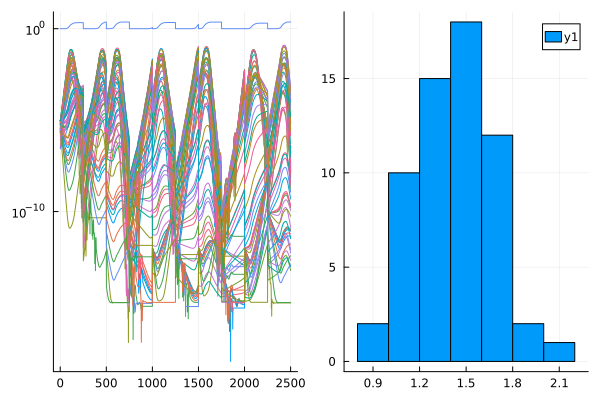

In [7]:
p1 = plot(abs.(NPt[1:S+1, :]' .+ 1e-15), yscale=:log10, leg=false)
p2 = histogram(p_opt_vec)
plot(p1, p2)

#### Determine dimension of attractor (using correlation dimension)

Dimensions: (1.2234030820045567, 1.2170889655300052, 1.2297499553834788)


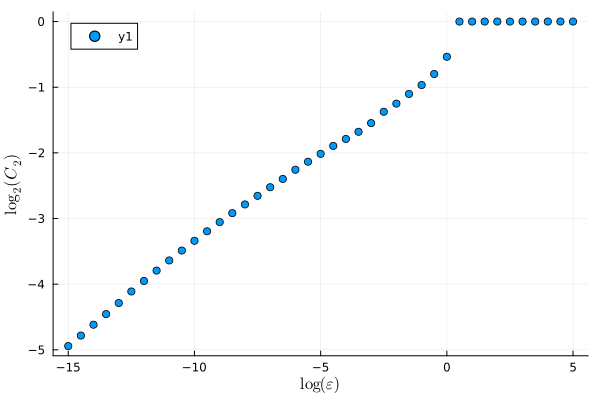

In [10]:
ϵς = 2 .^ (-15:0.5:5) # semi-random guess
Cs = correlationsum(NPt[S+1, :], ϵς; show_progress = false);

xs = log2.(ϵς)
ys = log2.(Cs)

Δ = slopefit(xs, ys, LargestLinearRegion())

scatter(xs, ys; ylabel = L"$\log_{2}(C_2)$", xlabel = L"$\log (\epsilon)$")
println("Dimensions: ", 2 .^ Δ)
current()